# Analiza danych przestrzennych - ćwiczenia laboratoryjne 2022/2023

Ten notatnik zalicza się do grupy zestawów zadań, na podstawie których odbywa się zaliczenie ćwiczeń i podlega zwrotowi do oceny w ustalonym na zajęciach terminie.

Uwagi ogólne:
- Podczas wykonywania zadań należy korzystać wyłącznie z pakietów zaimportowanych na początku notatnika oraz z pakietów wchodzących w skład standardowej biblioteki Pythona, które można zaimportować samodzielnie we wskazanej komórce.
- Swoje rozwiązania należy wprowadzać wyłącznie w miejce następujących fragmentów kodu:<br/> ` # YOUR CODE HERE`<br/> ` raise NotImplementedError()`<br/> Nie należy w żaden sposób modyfikować pozostałych fragmentów kodu oraz elementów notatnika, w szczególności dodawać lub usuwać komórek oraz zmieniać nazwy pliku.
- Jeżeli zestaw zadań wymaga skorzystania z funkcji przygotowanych w ramach wcześniejszych zestawów zadań należy je umieścić we wskazanej komórce.
- Wszystkie wykresy powinny być wykonane w jednolitym, przejrzystym i czytelnym stylu, mieć nadane tytuły, opisane osie oraz odpowiednio dobrany rozmiar, wielkość punktów i grubość linii. Proporcje osi wykresów przedstawiających rozkłady punktów powinny być dobrane tak, aby wykresy odzwierciedlały rzeczywisty rozkład punktów w przestrzeni.
- Zadania, które powodują wyświetlenie komunikatu o błędzie przerywającym wykonywanie kodu nie podlegają ocenie.

Przed odesłaniem zestawu zadań do oceny proszę uzupełnić komórkę z danymi autorów rozwiązania (`NAME` - nazwa grupy, `COLLABORATORS` - imiona, nazwiska i numery indeksów członków grupy) oraz upewnić się, że notatnik działa zgodnie z oczekiwaniami. W tym celu należy skorzystać z opcji **Restart Kernel and Run All Cells...** dostępnej na górnej belce notatnika pod symbolem $\blacktriangleright\blacktriangleright$. 

In [ ]:
COLLABORATORS = "Nawara Joanna, Śliwa Karol, Kopeć Marta"

---

## Zestaw zadań 8: Analiza danych przestrzennych z wykorzystaniem pakietów GeoPandas i PySAL (część 2)

In [197]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import libpysal as ps
import pointpats as pp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Miejsce do importu pakietów wchodzących w skład standardowej biblioteki Pythona oraz ustawienie opcji wykorzystywanych pakietów

In [109]:
# Miejsce do wklejenie funkcji ze wcześniejszych zestawów zadań
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: ignored

In [198]:
# Przydatne funkcje

def geopandas2pysal(polygon):
    x,y = polygon.exterior.coords.xy
    coords = np.dstack((x,y)).tolist()
    polygon = ps.cg.Polygon(coords)
    return polygon

#### UWAGA!
Znaczna część przykładów i dokumentacji modułów wchodzących w skład pakietu pysal dostępna w internecie nie dotyczny ich najnowszych wersji.
Z tego powodu wygodniejszym sposobem zdobywania informacji na temat wykorzystywanych modułów, klas i funkcji jest wykorzystanie funkcji help(), np.: help(ps), help(pp), help(pp.pointpattern).

### Zadanie 1: Import i przygotowanie danych (5 pkt)
Wykorzystując funkcję `geopandas.read_file()` zaimportuj do notatnika dane z dołączonego do niego pliku (zakres importowanych danych i odwzorowanie kartograficzne nie wymagają zmian). Następnie, wykorzystując funkcję `geopandas.GeoDataFrame.dissolve()` przygotuj tablicę zawierającą geometrię granic całego kraju. Dostosuj informację znajdującą się w kolumnie "Nazwa" stworzonej tablicy do informacji w niej zawartej.

In [199]:
powiaty_file = "Powiaty.zip!/Powiaty.dbf"
powiaty = gpd.read_file(powiaty_file)
kraj = powiaty.dissolve()
kraj['Nazwa'] = 'Polska'
kraj
crs=kraj.crs

### Zadanie 2: Jednorodny proces punktowy Poissona (15 pkt)

Przygotuj funkcję `homogeneous_poisson_on_polygon()`, która będzie generować jednorodny proces punktowy Poissona w obrębie określonego obszaru.
Następnie wykorzystaj przygotowaną funkcję do wygenerowania przykładowego rozkładu punktów i przedstaw go w postaci wykresu punktowego nałożonego na kontur granic kraju.

Parametry rozkładu do wygenerowania:
 - intensywność procesu: $3 \cdot 10^{-9} pkt/m^2$ 
 - obszar: Polska
 - crs: idenyczny jak crs wczytanych danych
 
Przydatne klasy, funkcje i własności:
- `pointpats.as_window()`
- `pointpats.Window()`
- `pointpats.process.PoissonPointProcess()`
- `geopandas.GeoSeries.area`
- `geopandas.GeoSeries.from_xy()`
- `geopandas.GeoSeries.crs`
- `geopandas.GeoSeries.set_crs()`
- `geopandas.GeoDataFrame.crs`
- `geopandas.GeoDataFrame.set_crs()`
- `geopandas2pysal()` - dostępna na początku notatnika

#### a) Przygotowanie funkcji

In [200]:
def homogeneous_poisson_on_polygon(intensity, polygon, crs):
    """
    Parameters
    -------
    intensity: float
        Liczba dodatnia określająca intensywność procesu punktowego.
    polygon: libpysal.cg.shapes.Polygon
        Poligon określający obszar, na którym mają zostać wygenerowane punkty.
    crs: str, pyproj.crs.crs.CRS
        Informacja o odwzorowaniu kartograficznym, w który zapisany jest poligon i w którym mają być zapisane wygenerowane punkty.
    Returns
    -------
    points: GeoSeries
        Seria GeoPandas zawierająca wygnerowane punkty zapisane jako obiekty shapely.geometry.point.Point.
    """
    
    window = pp.as_window(polygon)
    poisson = pp.process.PoissonPointProcess(window, round(intensity*window.area), 1, False, False)
    x = poisson.realizations[0][:,0]
    y = poisson.realizations[0][:,1]

    points = gpd.GeoSeries.from_xy(x, y, crs=crs)
    return points
    
    

#### b) Wygenerowanie danych

In [201]:
kraj_p = geopandas2pysal(kraj['geometry'][0])
crs
points = homogeneous_poisson_on_polygon(3e-9, kraj_p, crs)


#### c) Wizualizacja

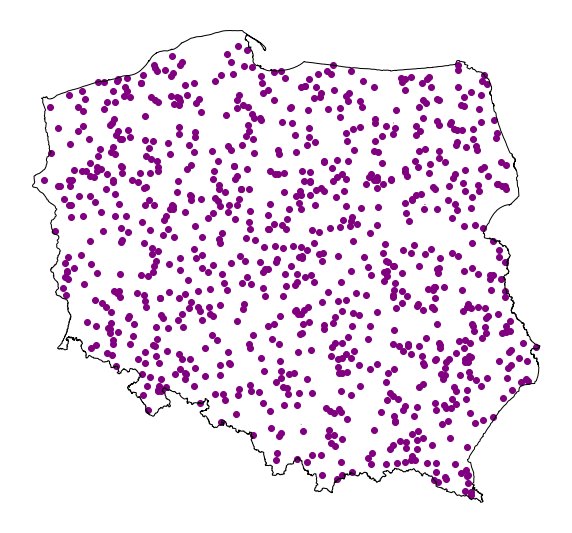

In [202]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

kraj.boundary.plot(ax=ax, edgecolor='k', linewidth=1)
points.plot(ax=ax, color='purple')
ax.set_axis_off()
plt.show()


### Zadanie 3: Sklasteryzowany proces punktowy Poissona (15 pkt)

Przygotuj funkcję `clustered_poisson_on_polygon()`, która będzie generować sklasteryzowany proces punktowy Poissona (proces Neymana-Scotta) w obrębie określonego obszaru.
Następnie wykorzystaj przygotowaną funkcję do wygenerowania przykładowego rozkładu punktów i przedstaw go w postaci wykresu punktowego nałożonego na kontur granic kraju.

Parametry rozkładu do wygenerowania:
 - intensywność procesu macierzystego: $0.5 \cdot 10^{-10} pkt/m^2$ 
 - liczba punktów: $1000$
 - promień klastra: $50 km$
 - obszar: Polska
 - crs: idenyczny jak crs wczytanych danych

Przydatne klasy, funkcje i własności:
- `pointpats.as_window()`
- `pointpats.Window()`
- `pointpats.process.PoissonClusterPointProcess()`
- `geopandas.GeoSeries.area`
- `geopandas.GeoSeries.from_xy()`
- `geopandas.GeoSeries.crs`
- `geopandas.GeoSeries.set_crs()`
- `geopandas.GeoDataFrame.crs`
- `geopandas.GeoDataFrame.set_crs()`
- `geopandas2pysal()` - dostępna na początku notatnika

#### a) Przygotowanie funkcji

In [203]:
def clustered_poisson_on_polygon(parent_intensity, number_of_points, cluster_radius, polygon, crs):
    """
    Parameters
    -------
    parent_intensity: float
        Liczba dodatnia określająca intensywność macierzystego procesu punktowego.
    number_of_points: int
        Liczba dodatnia określająca ilość generowanych punktów.
    cluster_radius: float
        Liczba dodatnia określająca promień generowanych klastrów.
    polygon: libpysal.cg.shapes.Polygon
        Poligon określający obszar, na którym mają zostać wygenerowane punkty.
    crs: str, pyproj.crs.crs.CRS
        Informacja o odwzorowaniu kartograficznym, w który zapisany jest poligon i w którym mają być zapisane wygenerowane punkty.
    Returns
    -------
    points: GeoSeries
        Seria GeoPandas zawierająca wygnerowane punkty zapisane jako obiekty shapely.geometry.point.Point.
    """
    # YOUR CODE HERE
    window = pp.as_window(polygon)
    parents=round(parent_intensity*window.area)
    poisson = pp.process.PoissonClusterPointProcess(window, number_of_points, parents, cluster_radius, 1, False, False )
    x = poisson.realizations[0][:,0]
    y = poisson.realizations[0][:,1]

    points = gpd.GeoSeries.from_xy(x, y, crs=crs)
    return points
    

#### b) Wygenerowanie danych

In [204]:
# YOUR CODE HERE
kraj_p
crs
points_poisson_clustered=clustered_poisson_on_polygon(0.5e-10, 1000, 50000, kraj_p, crs)
points_poisson_clustered

0      POINT (706456.284 668299.030)
1      POINT (494201.620 709357.345)
2      POINT (614318.384 695938.529)
3      POINT (706665.345 361714.715)
4      POINT (612529.085 661430.175)
                   ...              
995    POINT (556311.908 375899.863)
996    POINT (376632.604 600660.044)
997    POINT (526734.391 402248.910)
998    POINT (841096.822 315452.520)
999    POINT (256716.734 429268.667)
Length: 1000, dtype: geometry

#### c) Wizualizacja

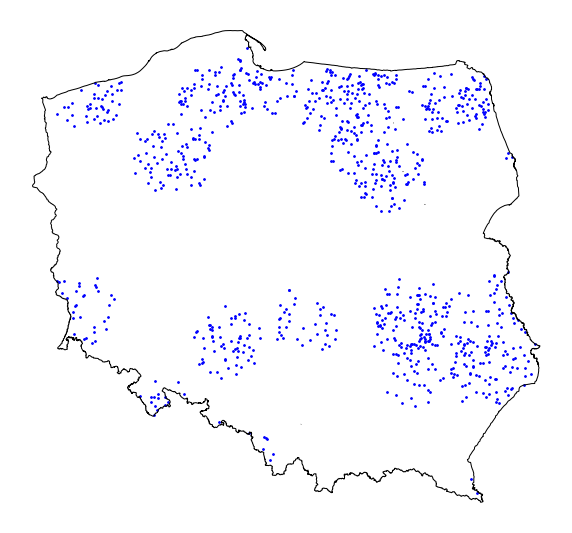

In [205]:
# YOUR CODE HERE
fig, ax = plt.subplots(1, 1, figsize=(10,10))
kraj.boundary.plot(ax=ax, edgecolor='k', linewidth=1)
points_poisson_clustered.plot(ax=ax, color='blue', markersize=3)
ax.set_axis_off()
plt.show()

### Zadanie 4: Badanie intensywności procesów punktowych metodą szacowania lokalnego  (15 pkt)

Przygotuj funkcję `point_count_on_subregions()`, która będzie zliczać punkty w obrębie podobszarów oraz funkcję `intensity_on_subregions()`, która będzie obliczać intensywność procesu punktowego w obrębie podobszarów.

Następnie wykorzystaj przygotowane funkcje do zbadania intensywności wszystkich przygotowanych rozkładów punktów na obszarze poszczegolnych powiatów.

Przedstaw wyniki analizy graficznie w postaci kartogramów z nałożonymi na nie rozkładami punktów. Zestaw wyniki na pojedynczej figurze (siatka wykresów 1x2).

Przydatne klasy, funkcje i własności:
- `geopandas.GeoSeries.within()`
- `geopandas.GeoSeries.area`

#### a) Przygotowanie funkcji

In [206]:
def point_count_on_subregions(points, subregions):
    """
    Parameters
    -------
    points: GeoSeries
        Tablica zawierająca punkty zapisane jako obiekty shapely.geometry.point.Point.
    subregions: GeoDataFrame
        Tablica zawierająca geometrie podobszarów zapisane jako obiekty shapely.geometry.polygon.Polygon.
    Returns
    -------
    counts: Series
        Seria Pandas zawierająca liczbą punktów przypisanych do każdego z podobszarów.
    """
    counts=[]
    for z in range(len(subregions)):
      counts.append(np.sum(points.within(subregions['geometry'][z])))
    return pd.Series(counts)

def intensity_on_subregions(points, subregions):
    """
    Parameters
    -------
    points: GeoSeries
        Tablica zawierająca punkty zapisane jako obiekty shapely.geometry.point.Point.
    subregions: GeoDataFrame
        Tablica zawierająca geometrie podobszarów zapisane jako obiekty shapely.geometry.polygon.Polygon.
    Returns
    -------
    counts: Series
        Seria Pandas zawierająca intensywność przypisaną do każdego z podobszarów.
    """
    # YOUR CODE HERE
    count = point_count_on_subregions(points, subregions)
    intensity = count / subregions.area
    return intensity
    

#### b) Wygenerowanie danych

In [207]:
# YOUR CODE HERE
hom_poiss_intens = intensity_on_subregions(points, powiaty)
clust_poiss_intens = intensity_on_subregions(points_poisson_clustered, powiaty)
powiaty_2 = powiaty
powiaty_2['hom_intensity'] = hom_poiss_intens
powiaty_2['clust_intensity'] = clust_poiss_intens


#### c) Wizualizacja

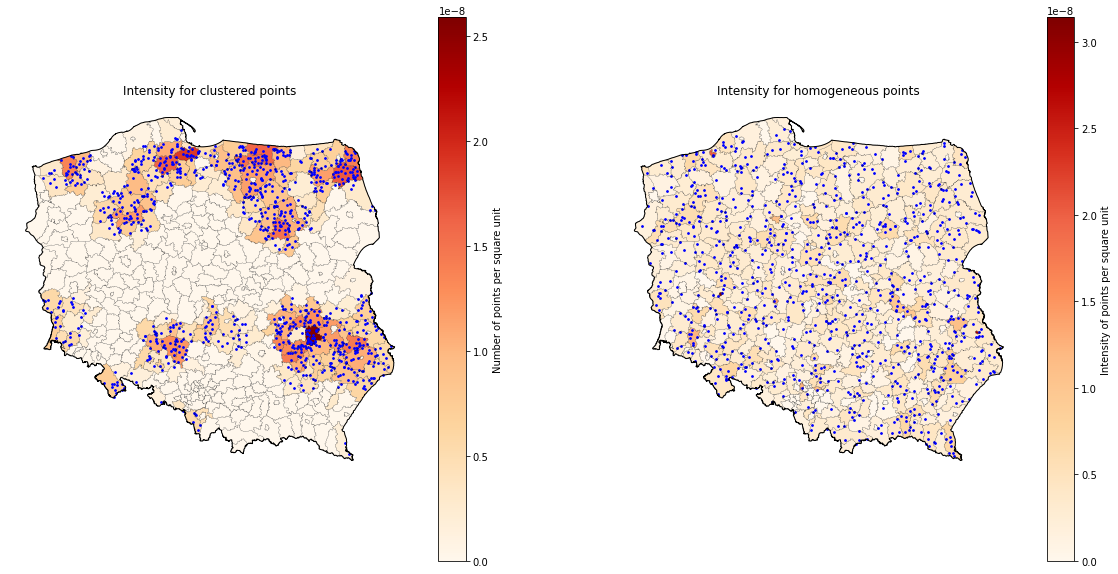

In [211]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
kraj.boundary.plot(edgecolor='k', linewidth=1, ax=ax[0])
powiaty_2.boundary.plot(ax=ax[0], edgecolor='k', linewidth=0.1)
powiaty_2.plot(column="clust_intensity", legend=True, legend_kwds={'label': "Number of points per square unit"}, cmap='OrRd', ax=ax[0])
points_poisson_clustered.plot(ax=ax[0], color='blue', markersize=3)
ax[0].set_title("Intensity for clustered points")
ax[0].set_axis_off()

kraj.boundary.plot(edgecolor='k', linewidth=1, ax=ax[1])
powiaty_2.boundary.plot(ax=ax[1], edgecolor='k', linewidth=0.1)
powiaty_2.plot(column="hom_intensity", legend=True, legend_kwds={'label': "Intensity of points per square unit"}, cmap='OrRd', ax=ax[1])
points.plot(ax=ax[1], color='blue', markersize=3)
ax[1].set_title("Intensity for homogeneous points")
ax[1].set_axis_off()

plt.show()
